# Cross-Source VIF & Correlation Analysis

Combined analysis of all 176 VIF-selected features across FRED (82), Unifier (41), and Prosper (53).
- Source-by-source correlation heatmaps
- Combined 176x176 correlation matrix
- Cross-source VIF pruning

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.dpi'] = 100
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

## 1. Load Latest Snapshots

In [2]:
base = Path('data/Exogenous_data')

fred = pd.read_parquet(base / 'exogenous_fred_data/decades/2020s/2026/2026-02.parquet')
uni  = pd.read_parquet(base / 'exogenous_unifier_data/decades/2020s/2026/2026-02.parquet')
pros = pd.read_parquet(base / 'prosper/decades/2020s/2026/2026-02.parquet')

fred['source'] = 'FRED'
uni['source']  = 'UNI'
pros['source'] = 'PROS'

combined = pd.concat([fred, uni, pros], ignore_index=True)

print(f'FRED:    {fred["series_name"].nunique():3d} features')
print(f'Unifier: {uni["series_name"].nunique():3d} features')
print(f'Prosper: {pros["series_name"].nunique():3d} features')
print(f'Total:   {combined["series_name"].nunique():3d} features')

FRED:     82 features
Unifier:  41 features
Prosper:  53 features
Total:   176 features


## 2. Pivot to Wide Format & Build Short Name Mapping

In [3]:
# Pivot each source separately then merge on date
wide_fred = fred.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')
wide_uni  = uni.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')
wide_pros = pros.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')

# Combined wide
wide_all = wide_fred.join(wide_uni, how='outer').join(wide_pros, how='outer')
wide_all = wide_all.sort_index()
print(f'Combined wide shape: {wide_all.shape}')
print(f'Date range: {wide_all.index.min()} to {wide_all.index.max()}')

Combined wide shape: (1286, 176)
Date range: 1919-01-01 00:00:00 to 2026-02-01 00:00:00


In [4]:
# ---- Short name mapping ----

def get_transform_suffix(name):
    """Extract transform type and return (base, suffix_tag)."""
    if name.endswith('_diff_zscore_12m'):
        return name[:-len('_diff_zscore_12m')], '_z12'
    elif name.endswith('_diff_zscore_3m'):
        return name[:-len('_diff_zscore_3m')], '_z3'
    elif name.endswith('_diff'):
        return name[:-len('_diff')], '_d'
    else:
        return name, ''

# FRED abbreviations
fred_base_abbrev = {
    'CCNSA_max_spike': 'CCNSA_spike',
    'CCNSA_monthly_avg': 'CCNSA_avg',
    'CCNSA_weeks_high': 'CCNSA_wkhi',
    'CCSA_max_spike': 'CCSA_spike',
    'CCSA_monthly_avg': 'CCSA_avg',
    'CCSA_weeks_high': 'CCSA_wkhi',
    'Credit_Spreads_accel_volatility': 'CrSpr_accvol',
    'Credit_Spreads_acceleration': 'CrSpr_acc',
    'Credit_Spreads_avg': 'CrSpr_avg',
    'Credit_Spreads_max': 'CrSpr_max',
    'Credit_Spreads_monthly_chg': 'CrSpr_chg',
    'Credit_Spreads_vol_of_changes': 'CrSpr_volchg',
    'Financial_Stress_monthly_avg': 'FinStr_avg',
    'ICNSA_monthly_avg': 'ICNSA_avg',
    'ICNSA_weeks_high': 'ICNSA_wkhi',
    'ICSA_max_spike': 'ICSA_spike',
    'ICSA_monthly_avg': 'ICSA_avg',
    'ICSA_weeks_high': 'ICSA_wkhi',
    'Oil_Prices_30d_crash': 'Oil_crash',
    'Oil_Prices_mean': 'Oil_mean',
    'Oil_Prices_volatility': 'Oil_vol',
    'Oil_Prices_zscore_min': 'Oil_zmin',
    'Oil_worst_day_pct': 'Oil_worst',
    'SP500_bear_market': 'SPX_bear',
    'SP500_best_day': 'SPX_best',
    'SP500_circuit_breaker': 'SPX_circuit',
    'SP500_consecutive_down_days': 'SPX_downdays',
    'SP500_crash_month': 'SPX_crash',
    'SP500_max_5d_drop': 'SPX_5ddrop',
    'SP500_max_drawdown': 'SPX_dd',
    'SP500_monthly_return': 'SPX_ret',
    'SP500_volatility': 'SPX_vol',
    'SP500_worst_day': 'SPX_worst',
    'VIX_30d_spike': 'VIX_30dspk',
    'VIX_high_regime': 'VIX_hireg',
    'VIX_max_5d_spike': 'VIX_5dspk',
    'VIX_max': 'VIX_max',
    'VIX_mean': 'VIX_mean',
    'VIX_panic_regime': 'VIX_panic',
    'VIX_volatility': 'VIX_vol',
    'Weekly_Econ_Index_monthly_avg': 'WEI_avg',
    'Weekly_Econ_Index_monthly_max': 'WEI_max',
    'Weekly_Econ_Index_monthly_min': 'WEI_min',
    'Yield_Curve_accel_volatility': 'YC_accvol',
    'Yield_Curve_acceleration': 'YC_acc',
    'Yield_Curve_avg': 'YC_avg',
    'Yield_Curve_monthly_chg': 'YC_chg',
    'Yield_Curve_vol_of_changes': 'YC_volchg',
    'Yield_Curve_zscore_max': 'YC_zmax',
}

# Unifier abbreviations
uni_base_abbrev = {
    'AHE_Private': 'AHE',
    'AWH_All_Private': 'AWH_All',
    'AWH_Manufacturing': 'AWH_Mfg',
    'CB_Consumer_Confidence': 'CB_Conf',
    'Challenger_Job_Cuts': 'Chall',
    'Empire_State_Mfg': 'Empire',
    'Housing_Starts': 'Housing',
    'ISM_Manufacturing_Index': 'ISM_Mfg',
    'ISM_NonManufacturing_Index': 'ISM_NMfg',
    'Industrial_Production': 'IndProd',
    'Retail_Sales': 'Retail',
    'UMich_Expectations': 'UMich',
}

# Prosper: question-to-code mapping
prosper_q_abbrev = {
    'Consumer Mood Index | Consumer Mood Index': 'Mood',
    'Prosper Consumer Spending Forecast | Consumer Spending Forecast': 'Spend',
}
# For the long layoff/employment questions, match by answer
prosper_answer_abbrev = {
    'Fewer': 'LayFwr',
    'More': 'LayMor',
    'Same': 'LaySam',
    'I am employed full-time': 'FT',
    'I am employed': 'Empl',
    'I am unemployed': 'Unemp',
    'I know people who have been laid off': 'KnowLO',
}
prosper_demo_abbrev = {
    '18-34': '1834',
    'Females': 'F',
    'Males': 'M',
    'US 18+': 'US',
}

def shorten_fred(name):
    base, suffix = get_transform_suffix(name)
    short_base = fred_base_abbrev.get(base, base)
    return f'F_{short_base}{suffix}'

def shorten_uni(name):
    base, suffix = get_transform_suffix(name)
    short_base = uni_base_abbrev.get(base, base)
    return f'U_{short_base}{suffix}'

def shorten_prosper(name):
    parts = name.split(' | ')
    if len(parts) == 3:
        q_part = f'{parts[0]} | {parts[1]}'
        demo_transform = parts[2]  # e.g., 'Females_diff_zscore_3m' or '18-34'
    elif len(parts) == 2:
        q_part = parts[0]
        demo_transform = parts[1]
    else:
        return f'P_{name[:20]}'
    
    # Get question/answer code
    q_code = prosper_q_abbrev.get(q_part)
    if q_code is None:
        # Must be layoff or employment question - use answer
        answer = parts[1].strip() if len(parts) >= 2 else ''
        q_code = prosper_answer_abbrev.get(answer, answer[:6])
    
    # Parse demographic + transform from demo_transform
    # Could be: 'Females_diff_zscore_3m', '18-34', 'Males', 'US 18+_diff_zscore_3m'
    demo_base, suffix = get_transform_suffix(demo_transform)
    demo = prosper_demo_abbrev.get(demo_base, demo_base[:4])
    
    return f'P_{q_code}_{demo}{suffix}'

# Build the mapping
name_map = {}
source_map = {}  # feature -> source

for f in sorted(wide_fred.columns):
    name_map[f] = shorten_fred(f)
    source_map[f] = 'FRED'

for f in sorted(wide_uni.columns):
    name_map[f] = shorten_uni(f)
    source_map[f] = 'UNI'

for f in sorted(wide_pros.columns):
    name_map[f] = shorten_prosper(f)
    source_map[f] = 'PROS'

# Check for duplicates in short names
short_names = list(name_map.values())
dupes = [n for n in short_names if short_names.count(n) > 1]
if dupes:
    print(f'WARNING: Duplicate short names: {set(dupes)}')
else:
    print('No duplicate short names')

print(f'\nMapping: {len(name_map)} features')
print('\nSample FRED mappings:')
for f in sorted(wide_fred.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')
print('\nSample Unifier mappings:')
for f in sorted(wide_uni.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')
print('\nSample Prosper mappings:')
for f in sorted(wide_pros.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')

No duplicate short names

Mapping: 176 features

Sample FRED mappings:
  CCNSA_max_spike_diff_zscore_3m                               -> F_CCNSA_spike_z3
  CCNSA_monthly_avg_diff_zscore_12m                            -> F_CCNSA_avg_z12
  CCNSA_weeks_high                                             -> F_CCNSA_wkhi
  CCSA_max_spike_diff_zscore_3m                                -> F_CCSA_spike_z3
  CCSA_monthly_avg                                             -> F_CCSA_avg

Sample Unifier mappings:
  AHE_Private                                                  -> U_AHE
  AHE_Private_diff                                             -> U_AHE_d
  AHE_Private_diff_zscore_12m                                  -> U_AHE_z12
  AHE_Private_diff_zscore_3m                                   -> U_AHE_z3
  AWH_All_Private                                              -> U_AWH_All

Sample Prosper mappings:
  Consumer Mood Index | Consumer Mood Index | 18-34_diff       -> P_Mood_1834_d
  Consumer Mood Index

In [5]:
# Prepare analysis data: 2010+ with forward-fill
wide_recent = wide_all.loc[wide_all.index >= '2010-01-01'].ffill()
print(f'Analysis data: {wide_recent.shape} (2010+, ffilled)')

# Check NaN coverage
nan_pct = wide_recent.isna().mean()
high_nan = nan_pct[nan_pct > 0.1]
if len(high_nan) > 0:
    print(f'\nFeatures with >30% NaN ({len(high_nan)}):')
    for f, pct in high_nan.sort_values(ascending=False).items():
        print(f'  {pct*100:5.1f}%  {name_map.get(f, f)}')
else:
    print('All features have <30% NaN - good')

Analysis data: (194, 176) (2010+, ffilled)

Features with >30% NaN (7):
   19.1%  P_Mood_1834_z3
   19.1%  P_Mood_F_z3
   19.1%  P_Mood_M_z3
   14.4%  P_Mood_1834_d
   14.4%  P_Mood_F_d
   12.9%  P_Mood_F
   12.9%  P_Mood_M


## 3. Source-by-Source Correlation Matrices

In [6]:
def plot_source_corr(wide_df, columns, source_name, name_map, figsize):
    """Plot correlation heatmap for a single source."""
    cols = sorted([c for c in columns if c in wide_df.columns])
    data = wide_df[cols].replace([np.inf, -np.inf], np.nan).dropna()
    short_names = [name_map.get(c, c[:20]) for c in cols]
    
    corr = data.corr()
    corr.index = short_names
    corr.columns = short_names
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', center=0,
                square=True, linewidths=0.1, linecolor='white',
                xticklabels=True, yticklabels=True,
                cbar_kws={'shrink': 0.8, 'label': 'Pearson r'},
                ax=ax)
    ax.set_title(f'{source_name} Correlation Matrix ({len(cols)} features)', fontsize=14, pad=12)
    ax.tick_params(axis='both', labelsize=6)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'corr_{source_name.lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print top 10 absolute correlations
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = upper.stack().reset_index()
    pairs.columns = ['f1', 'f2', 'r']
    pairs['abs_r'] = pairs['r'].abs()
    top = pairs.nlargest(20, 'abs_r')
    print(f'\nTop 10 correlations within {source_name}:')
    for _, row in top.iterrows():
        print(f'  {row["f1"]:25s} vs {row["f2"]:25s}  r={row["r"]:+.3f}')
    return corr

=== FRED (82 features) ===


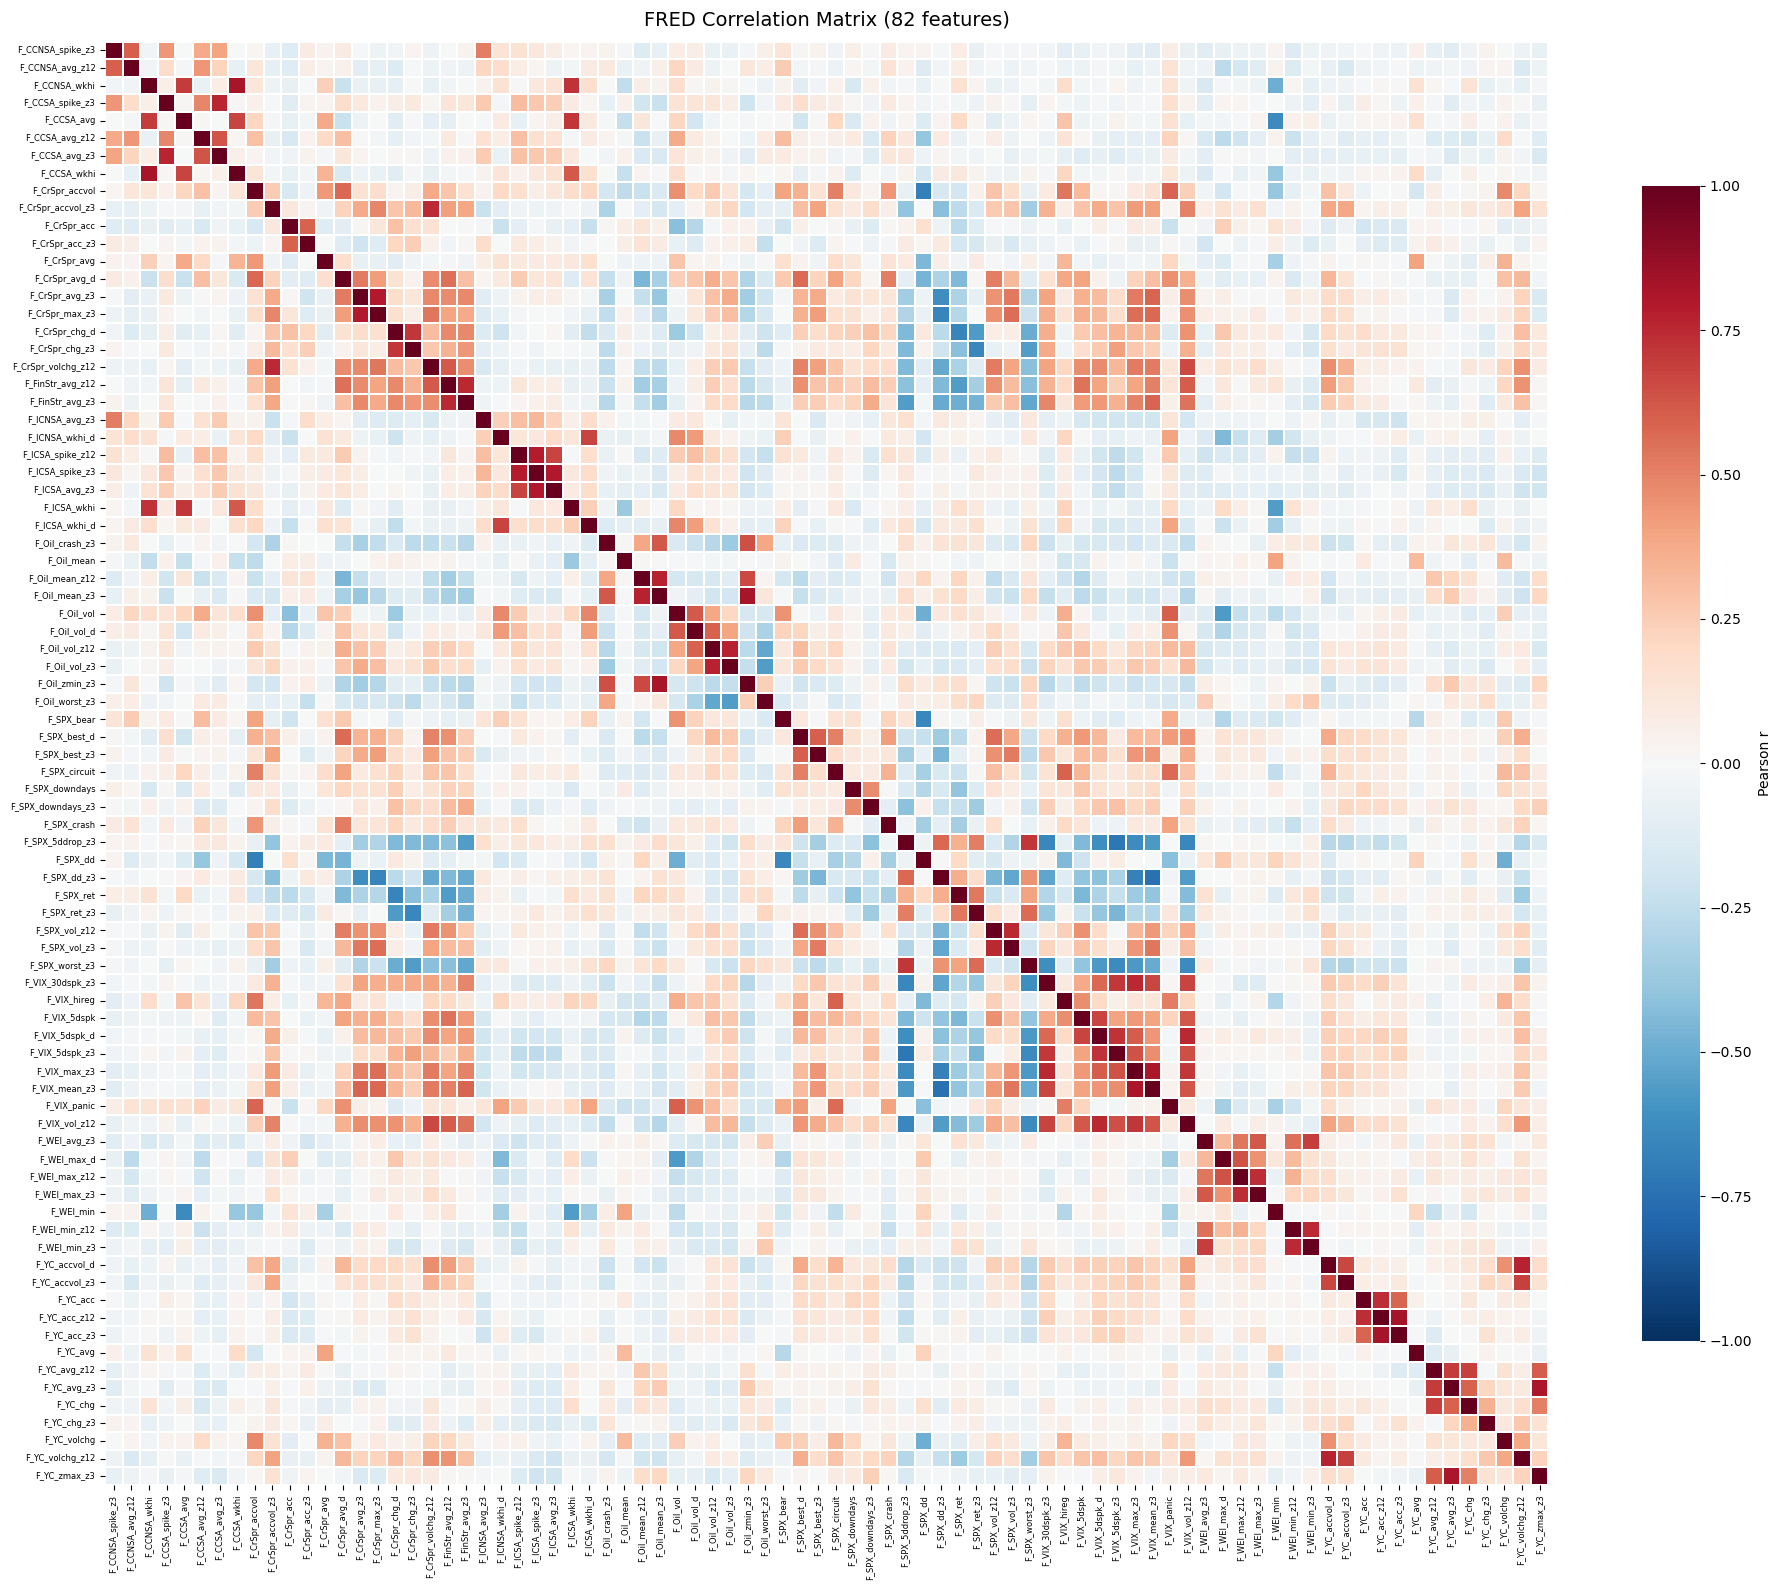


Top 10 correlations within FRED:
  F_YC_acc_z12              vs F_YC_acc_z3                r=+0.832
  F_Oil_mean_z3             vs F_Oil_zmin_z3              r=+0.826
  F_CCNSA_wkhi              vs F_CCSA_wkhi                r=+0.823
  F_YC_avg_z3               vs F_YC_zmax_z3               r=+0.818
  F_VIX_max_z3              vs F_VIX_mean_z3              r=+0.814
  F_ICSA_spike_z3           vs F_ICSA_avg_z3              r=+0.802
  F_CrSpr_avg_z3            vs F_CrSpr_max_z3             r=+0.796
  F_ICSA_spike_z12          vs F_ICSA_spike_z3            r=+0.784
  F_YC_accvol_d             vs F_YC_volchg_z12            r=+0.769
  F_Oil_vol_z12             vs F_Oil_vol_z3               r=+0.768
  F_Oil_mean_z12            vs F_Oil_mean_z3              r=+0.768
  F_CCSA_spike_z3           vs F_CCSA_avg_z3              r=+0.761
  F_FinStr_avg_z12          vs F_FinStr_avg_z3            r=+0.757
  F_VIX_5dspk_d             vs F_VIX_vol_z12              r=+0.756
  F_SPX_vol_z12             

In [7]:
# FRED correlation matrix
print('=== FRED (82 features) ===')
corr_fred = plot_source_corr(wide_recent, wide_fred.columns, 'FRED', name_map, (20, 16))

=== UNIFIER (41 features) ===


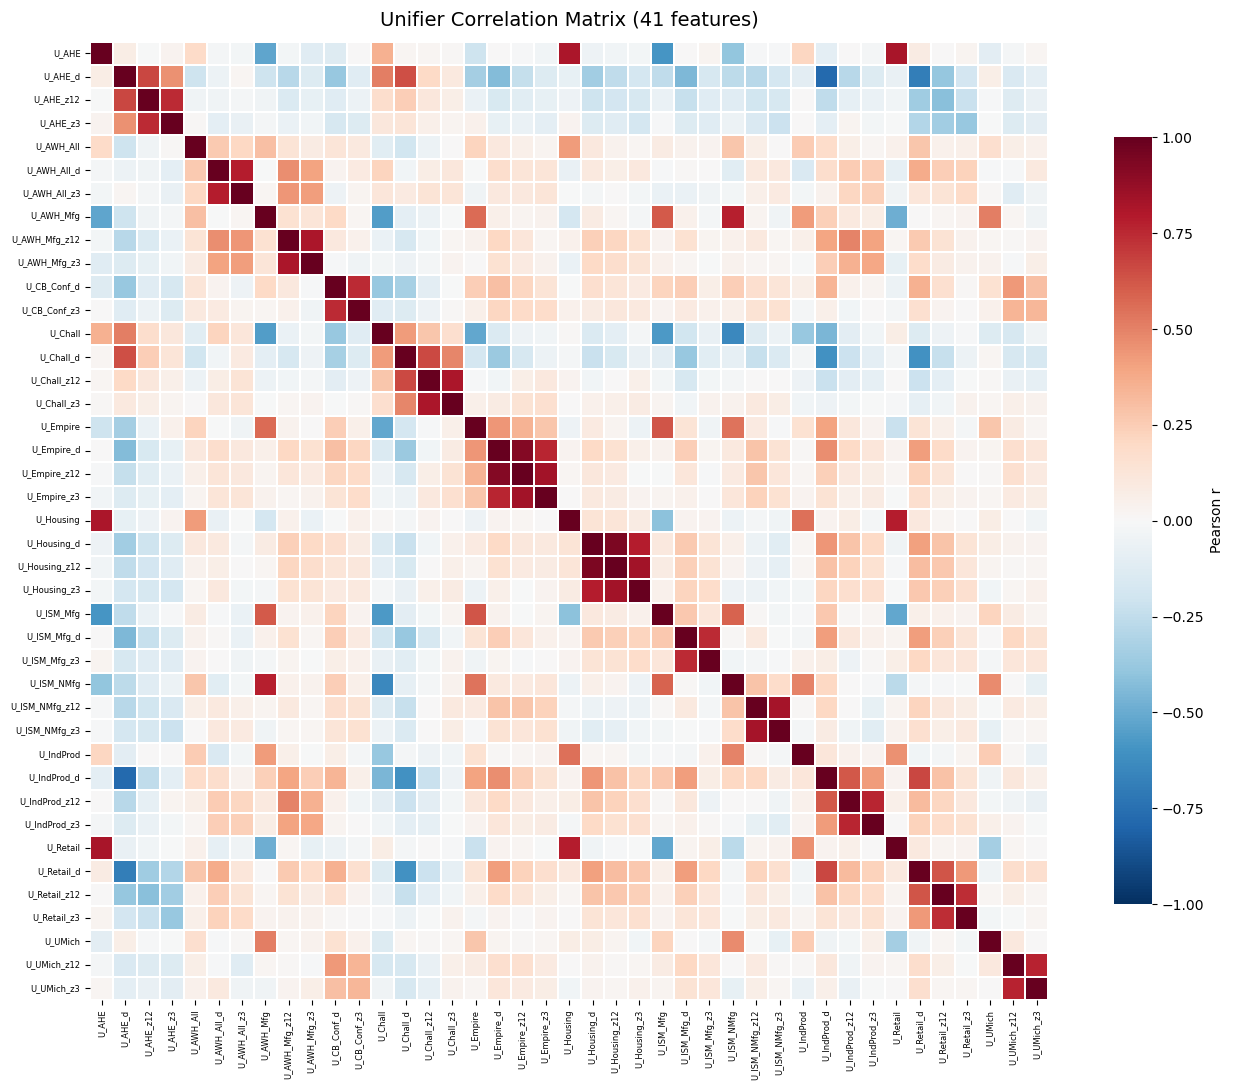


Top 10 correlations within Unifier:
  U_Housing_d               vs U_Housing_z12              r=+0.938
  U_Empire_d                vs U_Empire_z12               r=+0.915
  U_Empire_z12              vs U_Empire_z3                r=+0.841
  U_Housing_z12             vs U_Housing_z3               r=+0.837
  U_ISM_NMfg_z12            vs U_ISM_NMfg_z3              r=+0.833
  U_AHE                     vs U_Retail                   r=+0.828
  U_AHE                     vs U_Housing                  r=+0.820
  U_Chall_z12               vs U_Chall_z3                 r=+0.816
  U_AWH_Mfg_z12             vs U_AWH_Mfg_z3               r=+0.813
  U_Housing_d               vs U_Housing_z3               r=+0.788
  U_AWH_All_d               vs U_AWH_All_z3               r=+0.788
  U_Housing                 vs U_Retail                   r=+0.783
  U_AHE_d                   vs U_IndProd_d                r=-0.780
  U_AWH_Mfg                 vs U_ISM_NMfg                 r=+0.778
  U_UMich_z12            

In [8]:
# Unifier correlation matrix
print('=== UNIFIER (41 features) ===')
corr_uni = plot_source_corr(wide_recent, wide_uni.columns, 'Unifier', name_map, (14, 11))

=== PROSPER (53 features) ===


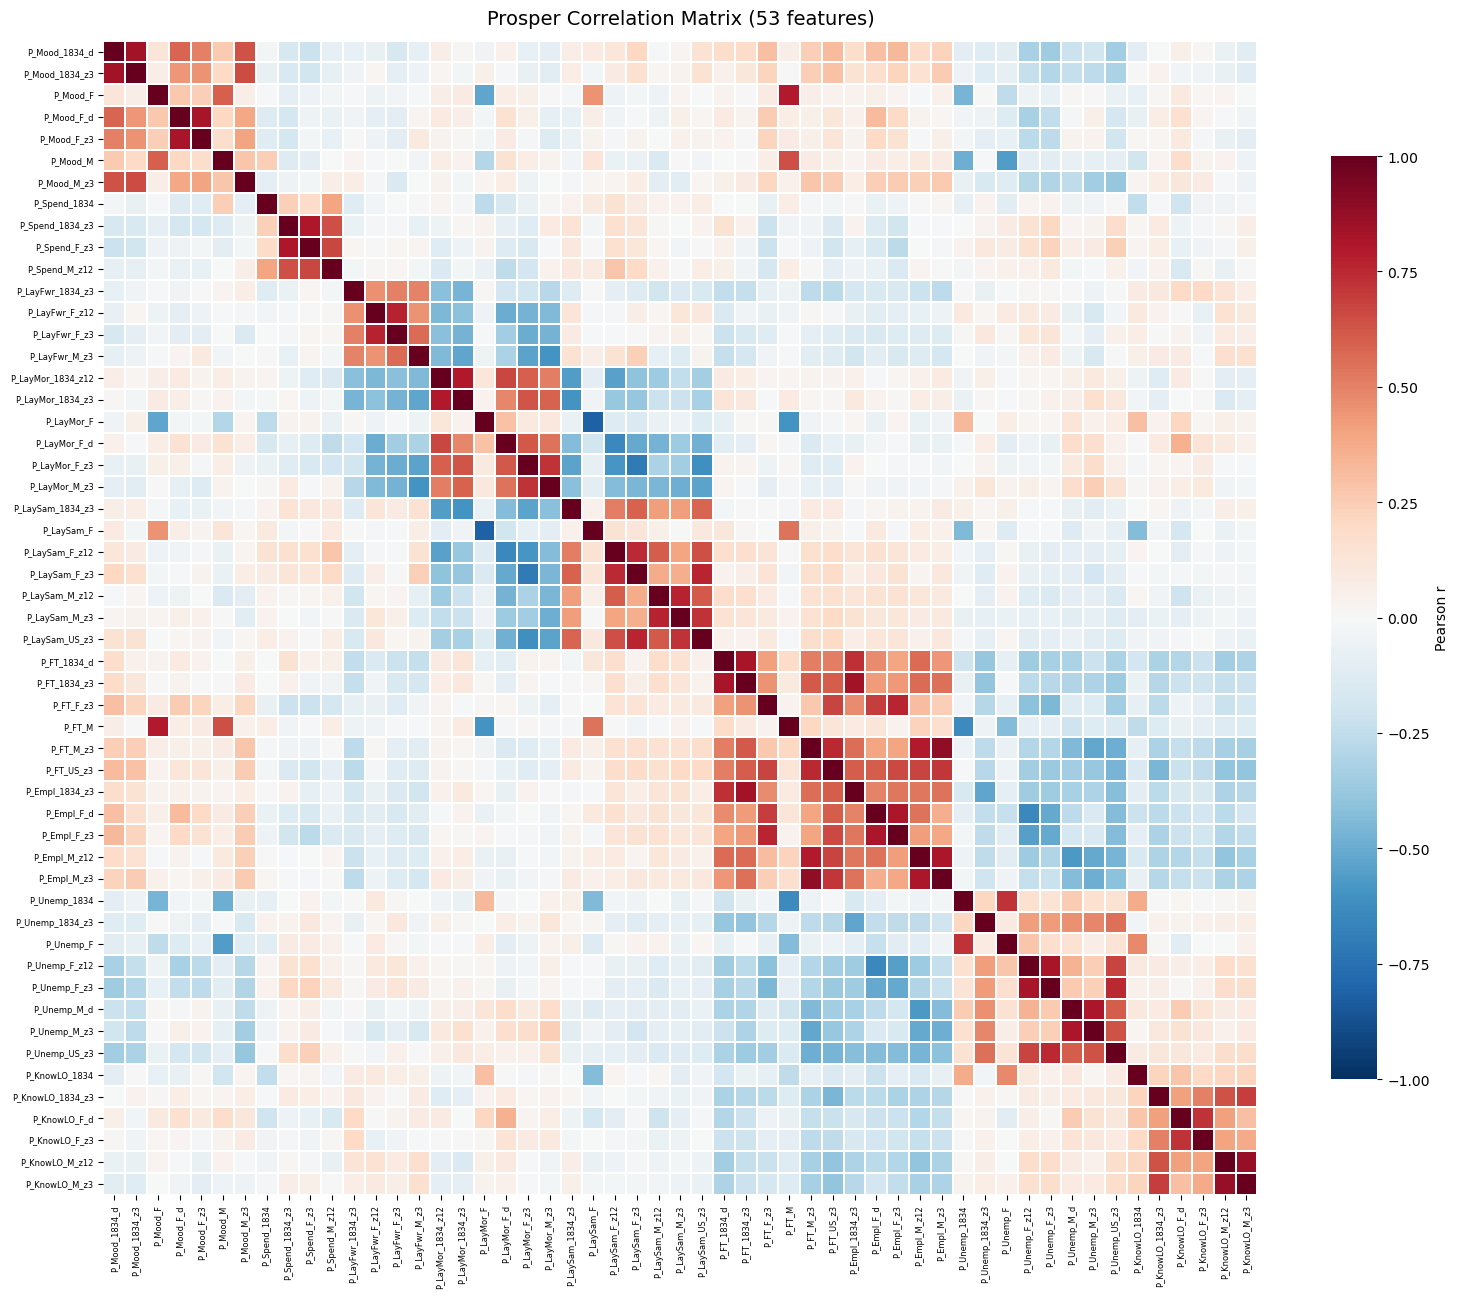


Top 10 correlations within Prosper:
  P_FT_M_z3                 vs P_Empl_M_z3                r=+0.888
  P_KnowLO_M_z12            vs P_KnowLO_M_z3              r=+0.868
  P_FT_1834_z3              vs P_Empl_1834_z3             r=+0.837
  P_Mood_1834_d             vs P_Mood_1834_z3             r=+0.837
  P_FT_1834_d               vs P_FT_1834_z3               r=+0.828
  P_Mood_F_d                vs P_Mood_F_z3                r=+0.827
  P_Unemp_F_z12             vs P_Unemp_F_z3               r=+0.821
  P_Empl_F_d                vs P_Empl_F_z3                r=+0.820
  P_Unemp_M_d               vs P_Unemp_M_z3               r=+0.819
  P_Empl_M_z12              vs P_Empl_M_z3                r=+0.818
  P_LayMor_F                vs P_LaySam_F                 r=-0.818
  P_Spend_1834_z3           vs P_Spend_F_z3               r=+0.812
  P_LayMor_1834_z12         vs P_LayMor_1834_z3           r=+0.799
  P_Mood_F                  vs P_FT_M                     r=+0.791
  P_FT_M_z3              

In [9]:
# Prosper correlation matrix
print('=== PROSPER (53 features) ===')
corr_pros = plot_source_corr(wide_recent, wide_pros.columns, 'Prosper', name_map, (16, 13))

## 4. Combined 176x176 Correlation Matrix

Combined correlation matrix: (176, 176)
Rows used for computation: 153


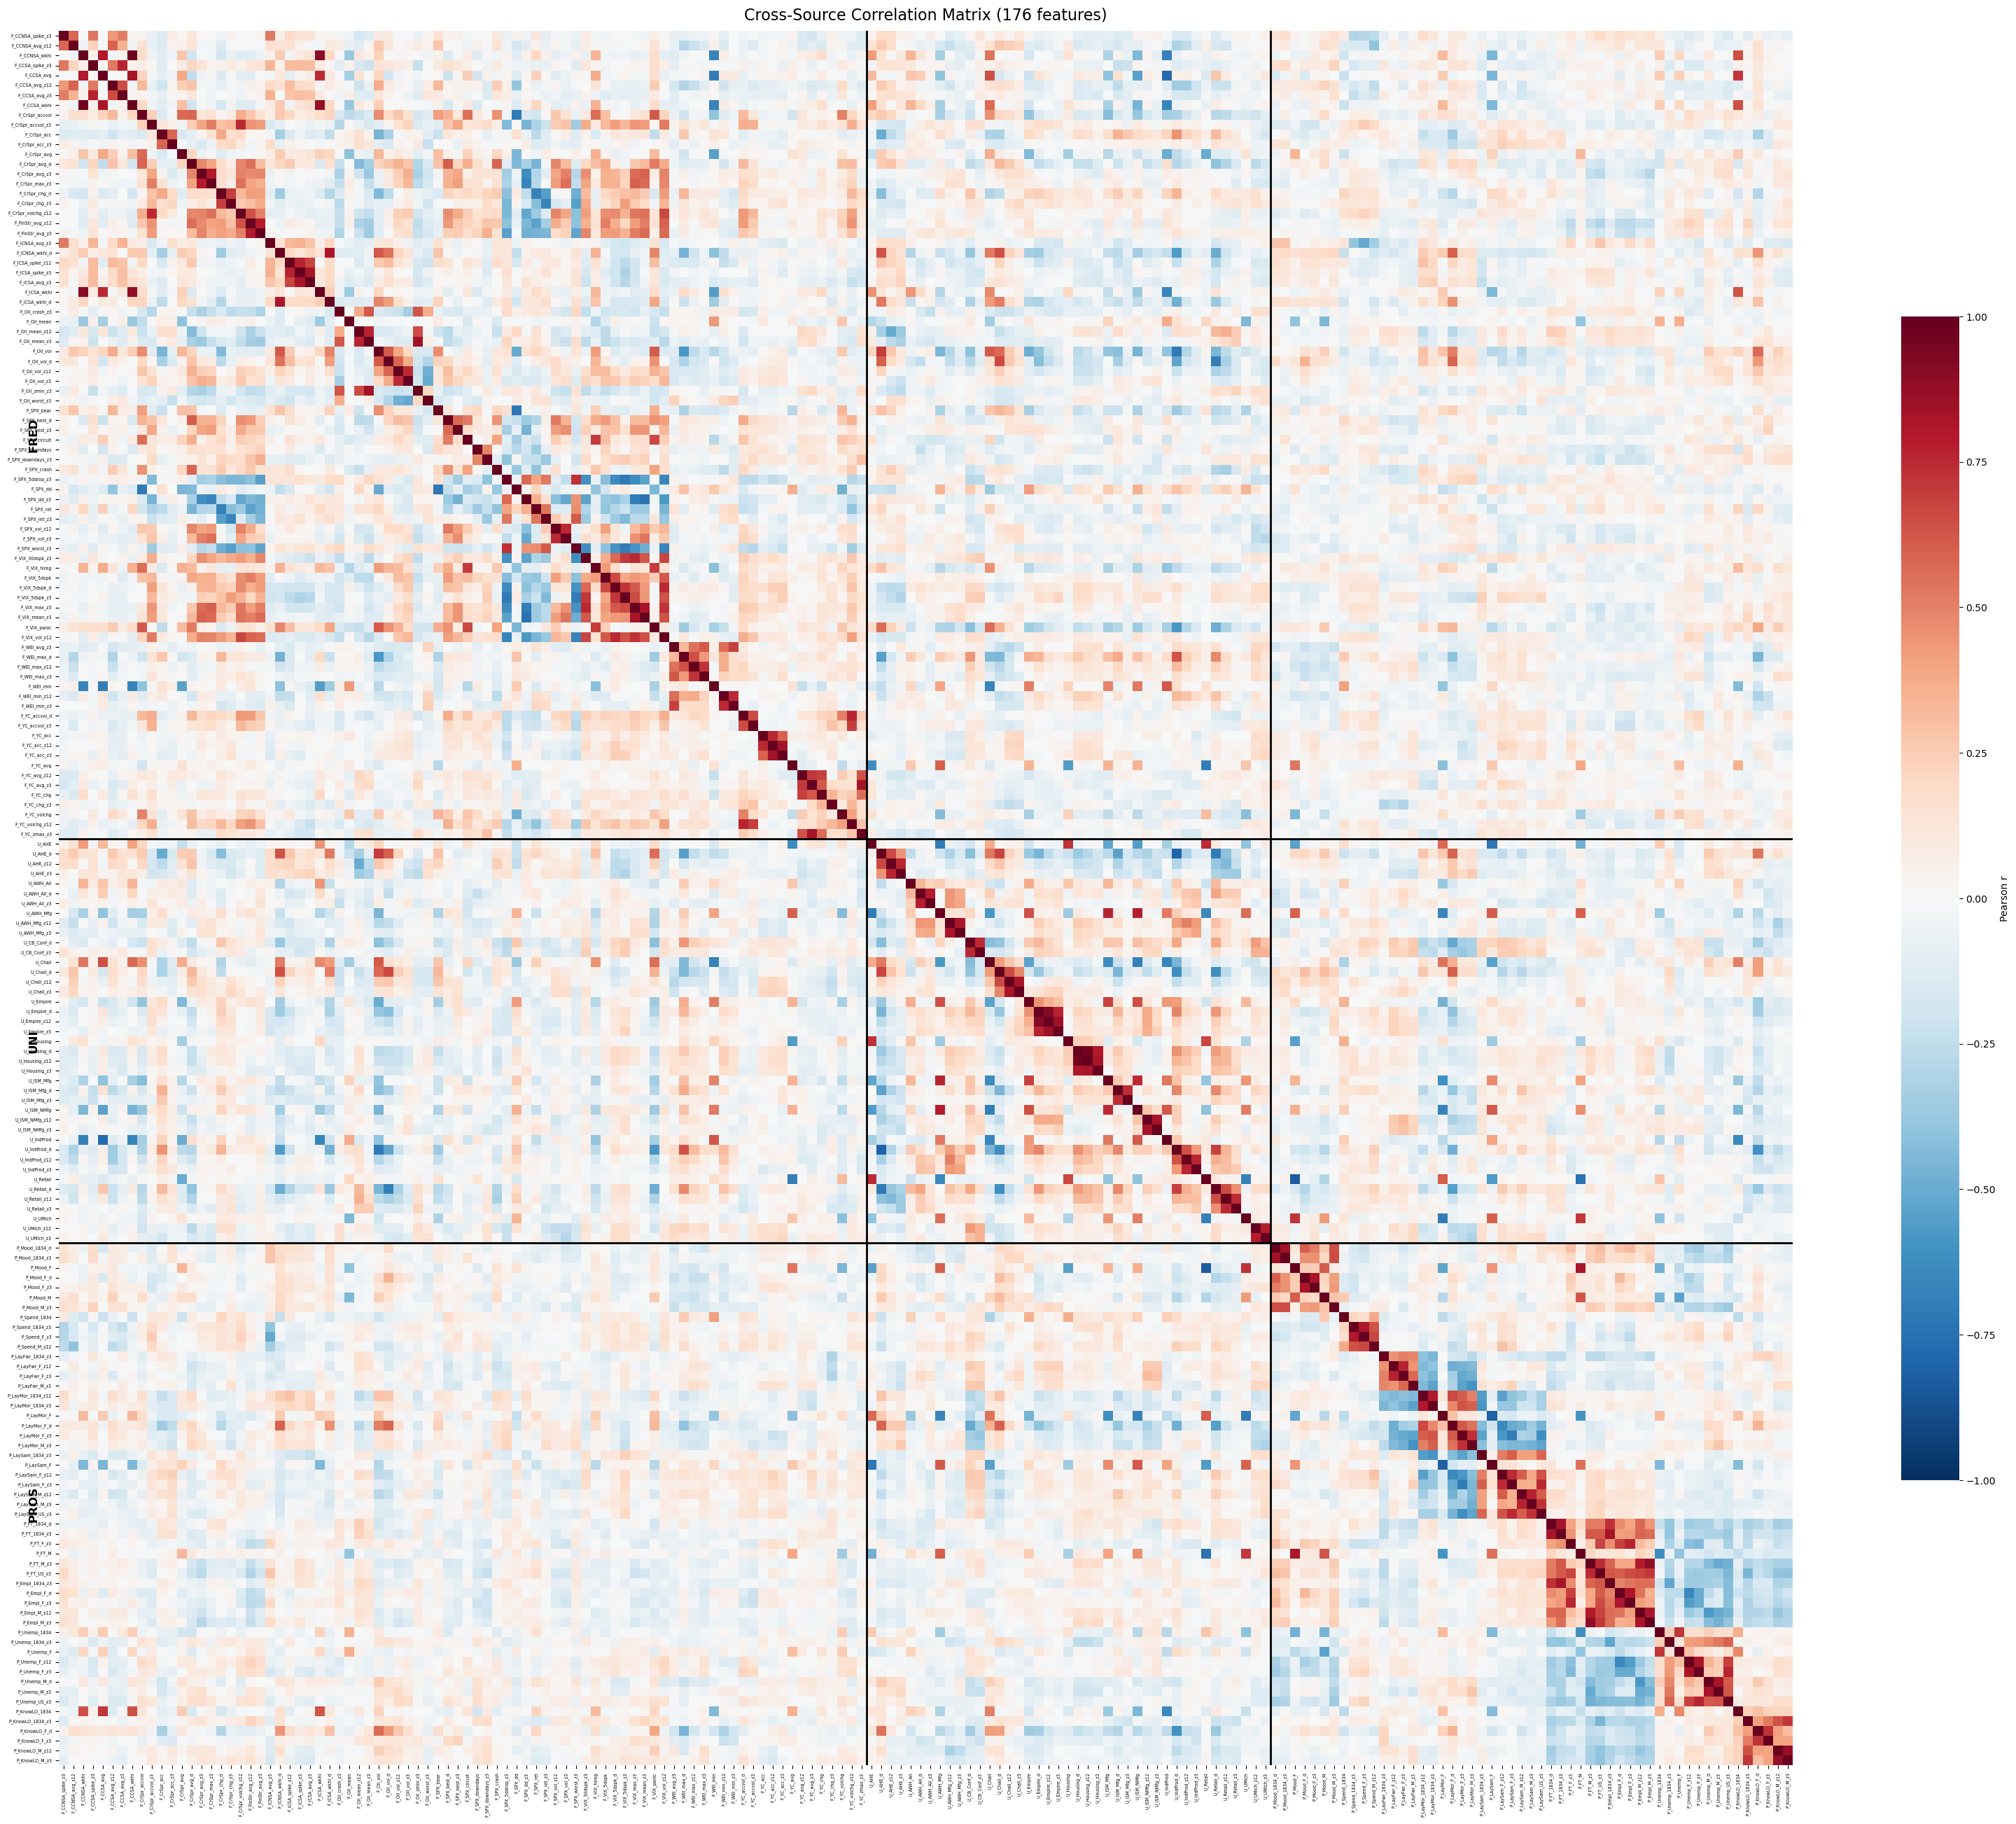

Saved to output.png


In [10]:
# Order: FRED, then Unifier, then Prosper
fred_cols = sorted([c for c in wide_fred.columns if c in wide_recent.columns])
uni_cols  = sorted([c for c in wide_uni.columns if c in wide_recent.columns])
pros_cols = sorted([c for c in wide_pros.columns if c in wide_recent.columns])
all_cols  = fred_cols + uni_cols + pros_cols

data = wide_recent[all_cols].replace([np.inf, -np.inf], np.nan).dropna()
short_labels = [name_map.get(c, c[:20]) for c in all_cols]

corr_all = data.corr()
corr_all.index = short_labels
corr_all.columns = short_labels

print(f'Combined correlation matrix: {corr_all.shape}')
print(f'Rows used for computation: {len(data)}')

# Plot
fig, ax = plt.subplots(figsize=(32, 28))
sns.heatmap(corr_all, vmin=-1, vmax=1, cmap='RdBu_r', center=0,
            square=True, linewidths=0, 
            xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.6, 'label': 'Pearson r'},
            ax=ax)

# Add source boundary lines
n_fred = len(fred_cols)
n_uni  = len(uni_cols)
n_pros = len(pros_cols)

for boundary in [n_fred, n_fred + n_uni]:
    ax.axhline(y=boundary, color='black', linewidth=2)
    ax.axvline(x=boundary, color='black', linewidth=2)

# Source labels on sides
ax.text(-2, n_fred/2, 'FRED', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)
ax.text(-2, n_fred + n_uni/2, 'UNI', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)
ax.text(-2, n_fred + n_uni + n_pros/2, 'PROS', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)

ax.set_title(f'Cross-Source Correlation Matrix ({len(all_cols)} features)', fontsize=16, pad=12)
ax.tick_params(axis='both', labelsize=4.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('output.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to output.png')

## 5. Top Cross-Source Correlations

In [11]:
# Build source lookup for short names
short_source = {}
for c in fred_cols:
    short_source[name_map[c]] = 'FRED'
for c in uni_cols:
    short_source[name_map[c]] = 'UNI'
for c in pros_cols:
    short_source[name_map[c]] = 'PROS'

# Get upper triangle pairs
upper = corr_all.where(np.triu(np.ones(corr_all.shape), k=1).astype(bool))
pairs = upper.stack().reset_index()
pairs.columns = ['f1', 'f2', 'r']
pairs['s1'] = pairs['f1'].map(short_source)
pairs['s2'] = pairs['f2'].map(short_source)
pairs['abs_r'] = pairs['r'].abs()

# Cross-source only
cross = pairs[pairs['s1'] != pairs['s2']].copy()
top_cross = cross.nlargest(30, 'abs_r')

print('Top 30 Cross-Source Correlations')
print('=' * 90)
for i, (_, row) in enumerate(top_cross.iterrows(), 1):
    print(f'  {i:2d}. [{row["s1"]:4s}] {row["f1"]:28s} vs [{row["s2"]:4s}] {row["f2"]:28s}  r={row["r"]:+.3f}')

# Summary by source pair
print('\nCross-source pairs with |r| > 0.5:')
for pair_name, s1, s2 in [('FRED-UNI', 'FRED', 'UNI'), ('FRED-PROS', 'FRED', 'PROS'), ('UNI-PROS', 'UNI', 'PROS')]:
    mask = ((cross['s1'] == s1) & (cross['s2'] == s2)) | ((cross['s1'] == s2) & (cross['s2'] == s1))
    high = cross[mask & (cross['abs_r'] > 0.5)]
    print(f'  {pair_name}: {len(high)} pairs')

Top 30 Cross-Source Correlations
   1. [UNI ] U_Retail                     vs [PROS] P_Mood_F                      r=-0.835
   2. [FRED] F_CCSA_avg                   vs [UNI ] U_IndProd                     r=-0.783
   3. [UNI ] U_Retail                     vs [PROS] P_FT_M                        r=-0.735
   4. [UNI ] U_AHE                        vs [PROS] P_LaySam_F                    r=-0.723
   5. [UNI ] U_UMich                      vs [PROS] P_Mood_F                      r=+0.723
   6. [FRED] F_CCSA_avg                   vs [PROS] P_KnowLO_1834                 r=+0.718
   7. [FRED] F_Oil_vol                    vs [UNI ] U_IndProd_d                   r=-0.716
   8. [UNI ] U_UMich                      vs [PROS] P_FT_M                        r=+0.705
   9. [UNI ] U_UMich                      vs [PROS] P_LayMor_F                    r=-0.703
  10. [FRED] F_Oil_vol                    vs [UNI ] U_AHE_d                       r=+0.702
  11. [FRED] F_YC_avg                     vs [UNI ] U_Ret

## 6. Cross-Source VIF Analysis

In [12]:
def iterative_vif_pruning(df_wide, features, threshold=10.0, verbose=True):
    """Iteratively remove highest-VIF feature until all below threshold."""
    cols = [c for c in features if c in df_wide.columns]
    X = df_wide[cols].replace([np.inf, -np.inf], np.nan).dropna()
    X = X.loc[:, X.var() > 0]
    removed = []
    iteration = 0
    while len(X.columns) > 2:
        iteration += 1
        X_const = X.copy()
        X_const['_const'] = 1.0
        vifs = {}
        for col in [c for c in X_const.columns if c != '_const']:
            try:
                vifs[col] = variance_inflation_factor(X_const.values, X_const.columns.get_loc(col))
            except:
                vifs[col] = np.inf
        max_col = max(vifs, key=vifs.get)
        max_vif = vifs[max_col]
        if max_vif <= threshold:
            break
        X = X.drop(columns=[max_col])
        removed.append((max_col, round(max_vif, 2)))
        if verbose and iteration <= 20:
            short = name_map.get(max_col, max_col[:30])
            src = source_map.get(max_col, '?')
            print(f'  Iter {iteration:3d}: Removed [{src:4s}] {short:30s} (VIF={max_vif:.1f})')
        elif verbose and iteration == 21:
            print(f'  ... (continuing)')
    if verbose and iteration > 20:
        print(f'  Total iterations: {iteration}')
    return X.columns.tolist(), removed

# Drop features with >30% NaN
nan_pct = wide_recent.isna().mean()
good_features = [f for f in all_cols if nan_pct.get(f, 1.0) <= 0.3]
dropped_nan = [f for f in all_cols if f not in good_features]
if dropped_nan:
    print(f'Dropped {len(dropped_nan)} features with >30% NaN:')
    for f in dropped_nan:
        print(f'  {name_map.get(f, f)} ({nan_pct[f]*100:.0f}% NaN)')

print(f'\nStarting VIF pruning with {len(good_features)} features (threshold=10.0)...')
final_survivors, final_removed = iterative_vif_pruning(
    wide_recent, good_features, threshold=10.0
)

print(f'\nFinal: {len(final_survivors)} features survived (removed {len(final_removed)})')

# Count by source
surv_fred = [f for f in final_survivors if source_map.get(f) == 'FRED']
surv_uni  = [f for f in final_survivors if source_map.get(f) == 'UNI']
surv_pros = [f for f in final_survivors if source_map.get(f) == 'PROS']
print(f'\nBy source:')
print(f'  FRED:    {len(surv_fred):3d} / 82  survived')
print(f'  Unifier: {len(surv_uni):3d} / 41  survived')
print(f'  Prosper: {len(surv_pros):3d} / 53  survived')


Starting VIF pruning with 176 features (threshold=10.0)...
  Iter   1: Removed [FRED] F_CCNSA_spike_z3               (VIF=inf)
  Iter   2: Removed [FRED] F_CCNSA_wkhi                   (VIF=inf)
  Iter   3: Removed [FRED] F_CCNSA_avg_z12                (VIF=inf)
  Iter   4: Removed [FRED] F_CCSA_spike_z3                (VIF=inf)
  Iter   5: Removed [FRED] F_CCSA_avg                     (VIF=inf)
  Iter   6: Removed [FRED] F_CCSA_avg_z12                 (VIF=inf)
  Iter   7: Removed [FRED] F_CCSA_avg_z3                  (VIF=inf)
  Iter   8: Removed [FRED] F_CCSA_wkhi                    (VIF=inf)
  Iter   9: Removed [FRED] F_CrSpr_accvol                 (VIF=inf)
  Iter  10: Removed [FRED] F_CrSpr_accvol_z3              (VIF=inf)
  Iter  11: Removed [FRED] F_CrSpr_acc                    (VIF=inf)
  Iter  12: Removed [FRED] F_CrSpr_acc_z3                 (VIF=inf)
  Iter  13: Removed [FRED] F_CrSpr_avg                    (VIF=inf)
  Iter  14: Removed [FRED] F_CrSpr_avg_d                

## 7. Final VIF Verification

In [13]:
# Compute final VIF for all survivors
cols = [c for c in final_survivors if c in wide_recent.columns]
X = wide_recent[cols].replace([np.inf, -np.inf], np.nan).dropna()
X = X.loc[:, X.var() > 0]
X_const = X.copy()
X_const['_const'] = 1.0

vif_final = []
for col in [c for c in X_const.columns if c != '_const']:
    try:
        vif = variance_inflation_factor(X_const.values, X_const.columns.get_loc(col))
    except:
        vif = np.nan
    vif_final.append({
        'feature': col,
        'short_name': name_map.get(col, col[:30]),
        'source': source_map.get(col, '?'),
        'VIF': round(vif, 2)
    })

vif_df = pd.DataFrame(vif_final).sort_values('VIF', ascending=False)

print('Final VIF Verification (all should be <= 10):')
print('=' * 70)
for _, row in vif_df.iterrows():
    print(f'  [{row["source"]:4s}] VIF={row["VIF"]:6.2f}  {row["short_name"]}')

print(f'\nMax VIF: {vif_df["VIF"].max():.2f}')
print(f'Mean VIF: {vif_df["VIF"].mean():.2f}')
print(f'Features with VIF > 10: {(vif_df["VIF"] > 10).sum()}')

Final VIF Verification (all should be <= 10):
  [FRED] VIF=  9.80  F_VIX_vol_z12
  [PROS] VIF=  9.70  P_Unemp_M_d
  [UNI ] VIF=  9.44  U_AHE_z12
  [FRED] VIF=  9.13  F_YC_avg_z12
  [UNI ] VIF=  8.99  U_AWH_All_d
  [PROS] VIF=  8.75  P_Unemp_M_z3
  [FRED] VIF=  8.64  F_YC_accvol_d
  [PROS] VIF=  8.57  P_Unemp_1834
  [FRED] VIF=  8.48  F_VIX_mean_z3
  [PROS] VIF=  8.45  P_LayMor_1834_z3
  [FRED] VIF=  8.35  F_Oil_mean_z12
  [UNI ] VIF=  8.34  U_AHE_z3
  [PROS] VIF=  8.26  P_Unemp_F
  [PROS] VIF=  8.22  P_Spend_1834_z3
  [UNI ] VIF=  8.11  U_Retail_z12
  [FRED] VIF=  8.09  F_ICSA_avg_z3
  [UNI ] VIF=  8.05  U_AWH_All_z3
  [FRED] VIF=  7.94  F_YC_chg
  [PROS] VIF=  7.94  P_LayFwr_F_z3
  [UNI ] VIF=  7.92  U_ISM_NMfg_z3
  [FRED] VIF=  7.88  F_SPX_dd
  [FRED] VIF=  7.68  F_SPX_5ddrop_z3
  [UNI ] VIF=  7.68  U_Housing_z3
  [FRED] VIF=  7.68  F_WEI_max_z3
  [FRED] VIF=  7.55  F_ICSA_spike_z3
  [FRED] VIF=  7.53  F_YC_volchg_z12
  [UNI ] VIF=  7.51  U_ISM_NMfg_z12
  [UNI ] VIF=  7.50  U_Housing

## 8. Summary & Output

In [14]:
print('CROSS-SOURCE SELECTED FEATURES')
print('=' * 70)
print(f'Total: {len(final_survivors)}')
print(f'  FRED:    {len(surv_fred)}')
print(f'  Unifier: {len(surv_uni)}')
print(f'  Prosper: {len(surv_pros)}')

print(f'\n--- FRED ({len(surv_fred)}) ---')
for f in sorted(surv_fred):
    print(f'  {name_map[f]:30s}  {f}')

print(f'\n--- Unifier ({len(surv_uni)}) ---')
for f in sorted(surv_uni):
    print(f'  {name_map[f]:30s}  {f}')

print(f'\n--- Prosper ({len(surv_pros)}) ---')
for f in sorted(surv_pros):
    print(f'  {name_map[f]:30s}  {f}')

# Features that were removed (cross-source redundancy)
print(f'\n\nREMOVED FEATURES ({len(final_removed)}):')
for f, vif in final_removed:
    src = source_map.get(f, '?')
    short = name_map.get(f, f[:30])
    print(f'  [{src:4s}] {short:30s}  VIF={vif}')

CROSS-SOURCE SELECTED FEATURES
Total: 100
  FRED:    45
  Unifier: 22
  Prosper: 33

--- FRED (45) ---
  F_ICSA_spike_z3                 ICSA_max_spike_diff_zscore_3m
  F_ICSA_avg_z3                   ICSA_monthly_avg_diff_zscore_3m
  F_ICSA_wkhi_d                   ICSA_weeks_high_diff
  F_Oil_crash_z3                  Oil_Prices_30d_crash_diff_zscore_3m
  F_Oil_mean                      Oil_Prices_mean
  F_Oil_mean_z12                  Oil_Prices_mean_diff_zscore_12m
  F_Oil_vol_d                     Oil_Prices_volatility_diff
  F_Oil_vol_z12                   Oil_Prices_volatility_diff_zscore_12m
  F_Oil_vol_z3                    Oil_Prices_volatility_diff_zscore_3m
  F_Oil_zmin_z3                   Oil_Prices_zscore_min_diff_zscore_3m
  F_Oil_worst_z3                  Oil_worst_day_pct_diff_zscore_3m
  F_SPX_bear                      SP500_bear_market
  F_SPX_best_d                    SP500_best_day_diff
  F_SPX_best_z3                   SP500_best_day_diff_zscore_3m
  F_SPX_circui

## 9. Feature Correlations with NFP Target (MoM Diff)

Compute Pearson correlation between ALL 176 features (before any VIF selection) and the NFP target MoM difference to assess explanatory power of each feature group.

In [15]:
# Load NFP target and compute MoM difference
target = pd.read_parquet('data/NFP_target/y_nsa_first_release.parquet')
target['y_diff'] = target['y'].diff()
target = target.dropna(subset=['y_diff'])
target['date'] = pd.to_datetime(target['ds'])
target = target.set_index('date')[['y_diff']]
print(f'Target: {len(target)} months, {target.index.min().strftime("%Y-%m")} to {target.index.max().strftime("%Y-%m")}')
print(f'Target MoM diff: mean={target["y_diff"].mean():.0f}, std={target["y_diff"].std():.0f}')

# Use ALL features (full wide_all, not just 2010+)
# Forward-fill to handle staggered start dates, then join with target
wide_for_corr = wide_all.ffill()
merged = wide_for_corr.join(target, how='inner')
print(f'\nMerged shape: {merged.shape} ({merged.shape[1]-1} features x {merged.shape[0]} months)')
print(f'Date range: {merged.index.min().strftime("%Y-%m")} to {merged.index.max().strftime("%Y-%m")}')

Target: 430 months, 1990-03 to 2025-12
Target MoM diff: mean=122, std=1452

Merged shape: (430, 177) (176 features x 430 months)
Date range: 1990-03 to 2025-12


In [16]:
# Compute correlation of each feature with target MoM diff
all_feature_cols = [c for c in merged.columns if c != 'y_diff']

corr_records = []
for feat in all_feature_cols:
    valid = merged[[feat, 'y_diff']].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid) >= 20:
        r = valid[feat].corr(valid['y_diff'])
        corr_records.append({
            'feature': feat,
            'short_name': name_map.get(feat, feat[:30]),
            'source': source_map.get(feat, '?'),
            'r': round(r, 4),
            'abs_r': round(abs(r), 4),
            'n_obs': len(valid),
        })

corr_df = pd.DataFrame(corr_records).sort_values('abs_r', ascending=False).reset_index(drop=True)
corr_df.index = corr_df.index + 1  # 1-indexed rank

# Identify feature group for analysis
def get_feature_group(feat, source):
    if source == 'UNI':
        base, _ = get_transform_suffix(feat)
        return f'UNI_{base}'
    elif source == 'PROS':
        parts = feat.split(' | ')
        if len(parts) >= 2:
            answer = parts[1].strip()
            for key in ['Consumer Mood Index', 'Consumer Spending Forecast']:
                if key in parts[0]:
                    return f'PROS_{key.split()[-1]}'
            return f'PROS_{answer[:20]}'
        return 'PROS_other'
    else:  # FRED
        base, _ = get_transform_suffix(feat)
        # Group by prefix
        for prefix in ['CCNSA', 'CCSA', 'Credit_Spreads', 'Financial_Stress',
                       'ICNSA', 'ICSA', 'Oil_Prices', 'Oil_worst',
                       'SP500', 'VIX', 'Weekly_Econ_Index', 'Yield_Curve']:
            if base.startswith(prefix):
                return f'FRED_{prefix}'
        return f'FRED_{base}'

corr_df['group'] = corr_df.apply(lambda row: get_feature_group(row['feature'], row['source']), axis=1)

print(f'Feature-Target Correlation Ranking (all {len(corr_df)} features)')
print('=' * 100)
print(f'{"Rank":>4s}  {"Source":5s}  {"Short Name":30s}  {"r":>8s}  {"|r|":>6s}  {"n":>4s}')
print('-' * 100)
for idx, row in corr_df.iterrows():
    print(f'{idx:4d}  [{row["source"]:4s}] {row["short_name"]:30s}  {row["r"]:+8.4f}  {row["abs_r"]:6.4f}  {row["n_obs"]:4d}')

Feature-Target Correlation Ranking (all 176 features)
Rank  Source  Short Name                             r     |r|     n
----------------------------------------------------------------------------------------------------
   1  [FRED] F_CCNSA_avg_z12                  -0.6407  0.6407   425
   2  [UNI ] U_AHE_d                          -0.6329  0.6329   237
   3  [UNI ] U_IndProd_d                      +0.5635  0.5635   430
   4  [FRED] F_WEI_max_d                      +0.5409  0.5409   215
   5  [UNI ] U_Chall_d                        -0.5306  0.5306   383
   6  [FRED] F_Oil_vol                        -0.4609  0.4609   430
   7  [UNI ] U_Chall                          -0.4373  0.4373   384
   8  [FRED] F_Oil_vol_d                      -0.4096  0.4096   430
   9  [UNI ] U_Retail_d                       +0.3933  0.3933   407
  10  [PROS] P_Spend_M_z12                    +0.3878  0.3878   268
  11  [FRED] F_CCNSA_spike_z3                 -0.3560  0.3560   429
  12  [UNI ] U_Empire_d     

In [17]:
# Group-level analysis: average |r| by feature group
group_stats = corr_df.groupby('group').agg(
    mean_abs_r=('abs_r', 'mean'),
    max_abs_r=('abs_r', 'max'),
    n_features=('abs_r', 'count'),
    best_feature=('abs_r', lambda x: corr_df.loc[x.idxmax(), 'short_name']),
    best_r=('r', lambda x: corr_df.loc[corr_df.loc[x.index, 'abs_r'].idxmax(), 'r']),
).sort_values('mean_abs_r', ascending=False)

print('Feature Group Rankings by Average |r| with NFP MoM Diff')
print('=' * 110)
print(f'{"Group":35s}  {"mean |r|":>8s}  {"max |r|":>7s}  {"#feat":>5s}  {"Best Feature":>30s}  {"r":>8s}')
print('-' * 110)
for grp, row in group_stats.iterrows():
    print(f'{grp:35s}  {row["mean_abs_r"]:8.4f}  {row["max_abs_r"]:7.4f}  {row["n_features"]:5.0f}  {row["best_feature"]:>30s}  {row["best_r"]:+8.4f}')

# Highlight CCSA, CCNSA, Credit Spreads
print('\n\n' + '=' * 80)
print('FOCUS: CCSA, CCNSA, Credit Spreads Feature Groups')
print('=' * 80)
for grp_prefix in ['FRED_CCSA', 'FRED_CCNSA', 'FRED_Credit_Spreads']:
    grp_feats = corr_df[corr_df['group'] == grp_prefix].copy()
    if grp_feats.empty:
        continue
    print(f'\n--- {grp_prefix} ({len(grp_feats)} features, mean |r|={grp_feats["abs_r"].mean():.4f}) ---')
    for _, row in grp_feats.iterrows():
        vif_status = 'KEPT' if row['feature'] in final_survivors else 'VIF-removed'
        print(f'  {row["short_name"]:30s}  r={row["r"]:+.4f}  |r|={row["abs_r"]:.4f}  [{vif_status}]')

Feature Group Rankings by Average |r| with NFP MoM Diff
Group                                mean |r|  max |r|  #feat                    Best Feature         r
--------------------------------------------------------------------------------------------------------------
FRED_CCNSA                             0.4007   0.6407      3                 F_CCNSA_avg_z12   -0.6407
UNI_Challenger_Job_Cuts                0.3559   0.5306      4                       U_Chall_d   -0.5306
PROS_Forecast                          0.2742   0.3878      4                   P_Spend_M_z12   +0.3878
UNI_AHE_Private                        0.2437   0.6329      4                         U_AHE_d   -0.6329
UNI_Industrial_Production              0.2344   0.5635      4                     U_IndProd_d   +0.5635
FRED_Weekly_Econ_Index                 0.2331   0.5409      7                     F_WEI_max_d   +0.5409
UNI_Empire_State_Mfg                   0.2118   0.3194      4                      U_Empire_d   +0.3194
U

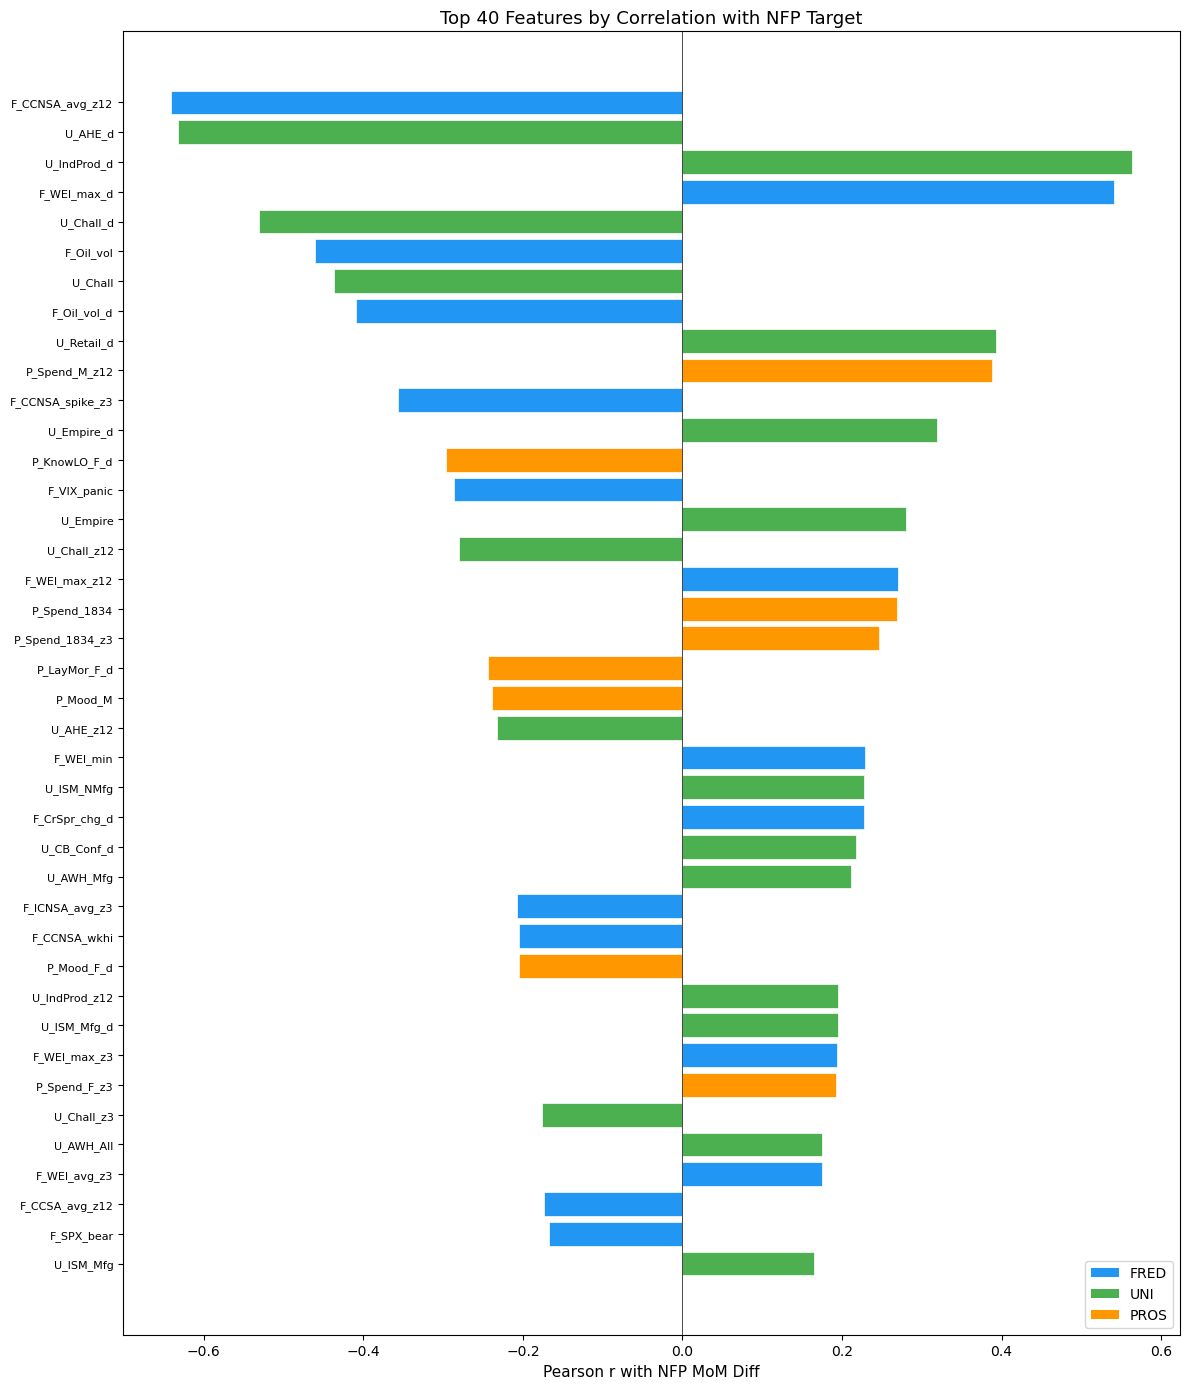

Saved to target_correlations.png


In [18]:
# Horizontal bar chart: top 40 features by |r| with target
top_n = 40
top_feats = corr_df.head(top_n).copy()
top_feats = top_feats.iloc[::-1]  # reverse for bottom-to-top plotting

# Color by source
colors = {'FRED': '#2196F3', 'UNI': '#4CAF50', 'PROS': '#FF9800'}
bar_colors = [colors.get(s, 'gray') for s in top_feats['source']]

fig, ax = plt.subplots(figsize=(12, 14))
bars = ax.barh(range(len(top_feats)), top_feats['r'], color=bar_colors, edgecolor='white', linewidth=0.5)
ax.set_yticks(range(len(top_feats)))
ax.set_yticklabels(top_feats['short_name'], fontsize=8)
ax.set_xlabel('Pearson r with NFP MoM Diff', fontsize=11)
ax.set_title(f'Top {top_n} Features by Correlation with NFP Target', fontsize=13)
ax.axvline(x=0, color='black', linewidth=0.5)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=s) for s, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('target_correlations.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to target_correlations.png')

In [19]:
# Summary: what the VIF pruning removed that had high target correlation
print('HIGH TARGET-CORRELATED FEATURES LOST TO VIF PRUNING')
print('=' * 90)
print('(Features with |r| >= 0.10 that were VIF-removed)')
print()

removed_set = set(f for f, _ in final_removed)
lost_valuable = corr_df[(corr_df['feature'].isin(removed_set)) & (corr_df['abs_r'] >= 0.10)]
lost_valuable = lost_valuable.sort_values('abs_r', ascending=False)

for _, row in lost_valuable.iterrows():
    vif_val = dict(final_removed).get(row['feature'], '?')
    print(f'  {row["short_name"]:30s}  r={row["r"]:+.4f}  |r|={row["abs_r"]:.4f}  VIF={vif_val}  [{row["source"]}]')

print(f'\nTotal lost with |r|>=0.10: {len(lost_valuable)} features')
print(f'Total lost with |r|>=0.15: {len(lost_valuable[lost_valuable["abs_r"] >= 0.15])} features')

# Compare: avg target correlation of VIF-kept vs VIF-removed
kept_corrs = corr_df[~corr_df['feature'].isin(removed_set)]['abs_r']
lost_corrs = corr_df[corr_df['feature'].isin(removed_set)]['abs_r']
print(f'\nAvg |r| with target:')
print(f'  VIF-kept ({len(kept_corrs)} features):    mean={kept_corrs.mean():.4f}, median={kept_corrs.median():.4f}')
print(f'  VIF-removed ({len(lost_corrs)} features): mean={lost_corrs.mean():.4f}, median={lost_corrs.median():.4f}')

HIGH TARGET-CORRELATED FEATURES LOST TO VIF PRUNING
(Features with |r| >= 0.10 that were VIF-removed)

  F_CCNSA_avg_z12                 r=-0.6407  |r|=0.6407  VIF=inf  [FRED]
  U_AHE_d                         r=-0.6329  |r|=0.6329  VIF=770.88  [UNI]
  U_IndProd_d                     r=+0.5635  |r|=0.5635  VIF=560.23  [UNI]
  F_WEI_max_d                     r=+0.5409  |r|=0.5409  VIF=127.38  [FRED]
  U_Chall_d                       r=-0.5306  |r|=0.5306  VIF=43.17  [UNI]
  F_Oil_vol                       r=-0.4609  |r|=0.4609  VIF=44.12  [FRED]
  U_Chall                         r=-0.4373  |r|=0.4373  VIF=1181.44  [UNI]
  U_Retail_d                      r=+0.3933  |r|=0.3933  VIF=49.66  [UNI]
  F_CCNSA_spike_z3                r=-0.3560  |r|=0.3560  VIF=inf  [FRED]
  U_Empire_d                      r=+0.3194  |r|=0.3194  VIF=32.48  [UNI]
  P_KnowLO_F_d                    r=-0.2969  |r|=0.2969  VIF=87.66  [PROS]
  F_VIX_panic                     r=-0.2870  |r|=0.2870  VIF=18.22  [FRED]
  

## 10. Comprehensive Feature Analysis CSV

For each of the 176 features: target correlation, number of highly-correlated peers (|r|>0.5 cross-source), which those peers are, and sum of all cross-feature |correlations|.

In [20]:
# Build comprehensive feature analysis across ALL sources
# Use the full wide_all (ffilled) joined with target for correlations

wide_for_analysis = wide_all.ffill()
merged_full = wide_for_analysis.join(target, how='inner')
all_feature_cols = [c for c in merged_full.columns if c != 'y_diff']

# 1. Compute target correlation for every feature
target_corrs = {}
for feat in all_feature_cols:
    valid = merged_full[[feat, 'y_diff']].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid) >= 20:
        target_corrs[feat] = round(valid[feat].corr(valid['y_diff']), 4)
    else:
        target_corrs[feat] = np.nan

# 2. Compute full cross-feature correlation matrix (all 176 features, across all sources)
analysis_data = wide_for_analysis[all_feature_cols].replace([np.inf, -np.inf], np.nan)
# Use 2005+ for broader coverage (Prosper starts ~2007, WEI starts ~2008)
analysis_recent = analysis_data.loc[analysis_data.index >= '2005-01-01'].dropna(how='all', axis=1)
# Pairwise correlation (uses pairwise complete obs by default)
cross_corr = analysis_recent.corr()

print(f'Cross-correlation matrix: {cross_corr.shape}')

# 3. For each feature: count peers with |r| > 0.5, list them, and sum of all |r|
rows = []
for feat in all_feature_cols:
    if feat not in cross_corr.columns:
        continue
    
    feat_corrs = cross_corr[feat].drop(feat, errors='ignore')  # exclude self
    
    # Peers with |r| > 0.5
    high_peers = feat_corrs[feat_corrs.abs() > 0.5].sort_values(key=abs, ascending=False)
    high_peer_names = []
    for peer, r_val in high_peers.items():
        short_peer = name_map.get(peer, peer[:25])
        high_peer_names.append(f'{short_peer} ({r_val:+.2f})')
    
    # Sum of all |r| (measure of total redundancy)
    sum_abs_r = round(feat_corrs.abs().sum(), 2)
    mean_abs_r = round(feat_corrs.abs().mean(), 4)
    
    rows.append({
        'feature': feat,
        'short_name': name_map.get(feat, feat[:30]),
        'source': source_map.get(feat, '?'),
        'target_r': target_corrs.get(feat, np.nan),
        'target_abs_r': abs(target_corrs.get(feat, 0)),
        'n_high_corr_peers': len(high_peers),
        'sum_abs_r_all': sum_abs_r,
        'mean_abs_r_all': mean_abs_r,
        'high_corr_peers': '; '.join(high_peer_names) if high_peer_names else '',
    })

feature_df = pd.DataFrame(rows)
feature_df = feature_df.sort_values('target_abs_r', ascending=False).reset_index(drop=True)
feature_df.index = feature_df.index + 1  # 1-indexed rank
feature_df.index.name = 'rank'

# Save to CSV
feature_df.to_csv('feature_analysis.csv')
print(f'Saved feature_analysis.csv with {len(feature_df)} features')
print(f'Columns: {list(feature_df.columns)}')

# Print summary
sep = '=' * 100
dash = '-' * 100
print(f'\n{sep}')
print('Top 30 features by target correlation (with redundancy info):')
print(sep)
print(f'{"Rank":>4s}  {"Source":5s}  {"Short Name":28s}  {"r(target)":>10s}  {"#Peers":>6s}  {"SumAbsR":>8s}  Top Peers')
print(dash)
for idx, row in feature_df.head(30).iterrows():
    peers_preview = row['high_corr_peers'][:60] + '...' if len(str(row['high_corr_peers'])) > 60 else row['high_corr_peers']
    print(f'{idx:4d}  [{row["source"]:4s}] {row["short_name"]:28s}  {row["target_r"]:+10.4f}  {row["n_high_corr_peers"]:6d}  {row["sum_abs_r_all"]:8.1f}  {peers_preview}')

# Features with high target |r| AND low redundancy
print()
print()
print('SWEET SPOT: Features with |r(target)| >= 0.15 and few peers (<5 with |r|>0.5)')
print(sep)
sweet = feature_df[(feature_df['target_abs_r'] >= 0.15) & (feature_df['n_high_corr_peers'] < 5)]
for idx, row in sweet.iterrows():
    print(f'  {row["short_name"]:28s}  r={row["target_r"]:+.4f}  peers={row["n_high_corr_peers"]}  sum|r|={row["sum_abs_r_all"]:.1f}  [{row["source"]}]')


Cross-correlation matrix: (176, 176)
Saved feature_analysis.csv with 176 features
Columns: ['feature', 'short_name', 'source', 'target_r', 'target_abs_r', 'n_high_corr_peers', 'sum_abs_r_all', 'mean_abs_r_all', 'high_corr_peers']

Top 30 features by target correlation (with redundancy info):
Rank  Source  Short Name                     r(target)  #Peers   SumAbsR  Top Peers
----------------------------------------------------------------------------------------------------
   1  [FRED] F_CCNSA_avg_z12                  -0.6407       1      14.2  F_CCNSA_spike_z3 (+0.59)
   2  [UNI ] U_AHE_d                          -0.6329       5      28.5  U_AHE_z12 (+0.70); U_IndProd_d (-0.69); U_Retail_d (-0.67); ...
   3  [UNI ] U_IndProd_d                      +0.5635       6      26.4  U_AHE_d (-0.69); F_Oil_vol (-0.69); U_IndProd_z12 (+0.64); U...
   4  [FRED] F_WEI_max_d                      +0.5409       3      21.1  F_WEI_max_z12 (+0.65); U_IndProd_d (+0.60); F_Oil_vol (-0.53...
   5  [UNI ] 